In [1]:
import subprocess
import os
print('Current conda environment:', os.environ['CONDA_DEFAULT_ENV'])
os.environ['TOKENIZERS_PARALLELISM'] = "false"

cwd = os.getcwd()
print(cwd)

import warnings
warnings.filterwarnings('ignore')

import random
random.seed(42)

Current conda environment: reinvent
/home/fts_g_ucla_edu/Projects/rips-relay/experiments


In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(rc = {'figure.figsize':(15,8)})

from crem.crem import grow_mol, mutate_mol
crem_db = '../crem_db/crem_db2.5.db'

import mols2grid

from rdkit import Chem
from rdkit.Chem import AllChem, rdFingerprintGenerator, CanonSmiles, Draw, MolFromSmiles, PandasTools
from rdkit.Chem.rdmolops import RDKFingerprint
from rdkit.Chem.Draw import MolsToGridImage
from rdkit import DataStructs
from rdkit.Chem.rdFMCS import FindMCS
from rdkit.DataStructs.cDataStructs import BulkTanimotoSimilarity
import useful_rdkit_utils as uru

import prolif as plf

import safe as sf
import datamol as dm

import mols2grid

from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, classification_report
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

import torch

from coati.generative.coati_purifications import embed_smiles
from coati.models.io.coati import load_e3gnn_smiles_clip_e2e
from coati.models.simple_coati2.io import load_coati2

Failed to find the pandas get_adjustment() function to patch
Failed to patch pandas - PandasTools will have limited functionality


In [3]:
pdb = '2zdt'

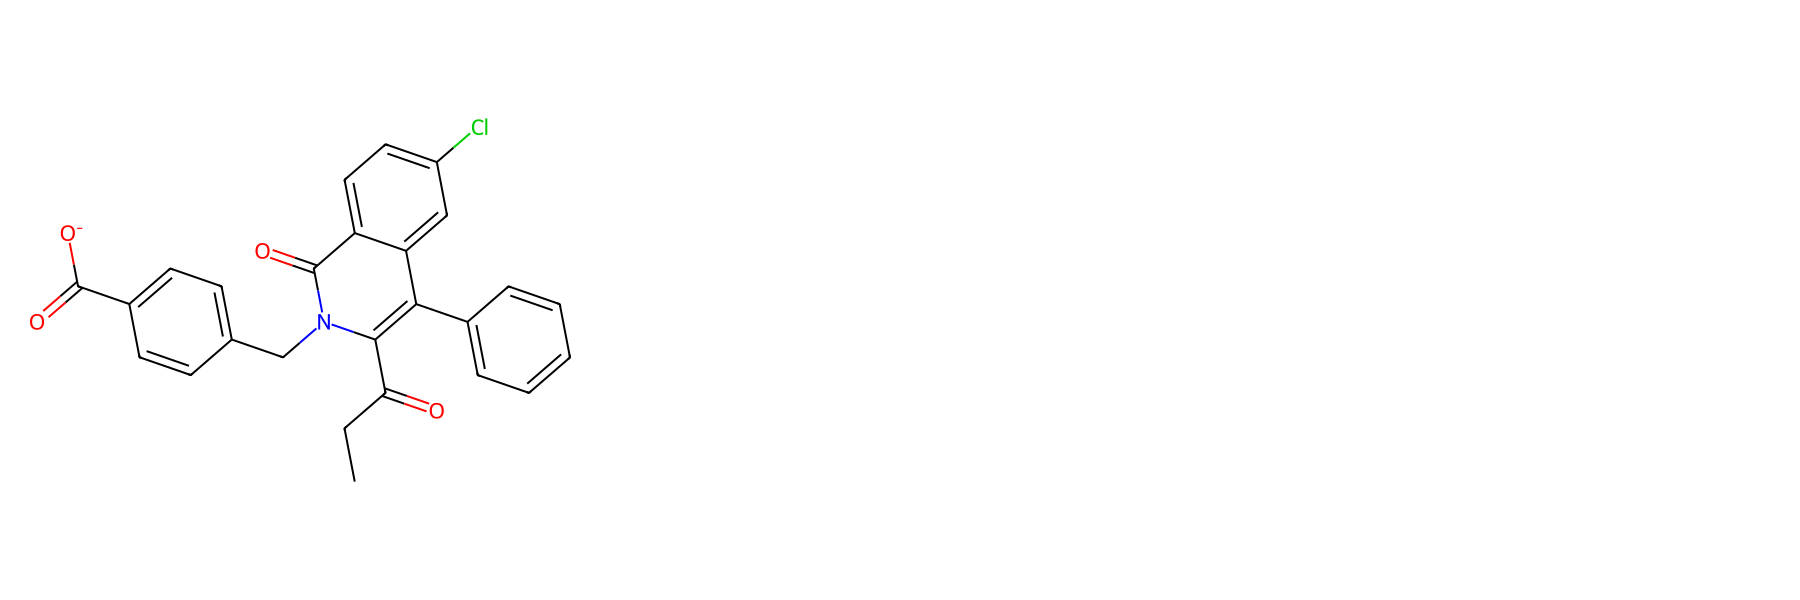

In [4]:
initial_mol = Chem.MolFromMolFile(f"data/docking/{pdb}_ligand.sdf")
initial = Chem.MolToSmiles(initial_mol)

MolsToGridImage([Chem.MolFromSmiles(initial)], subImgSize=(600, 600))

In [5]:
initial

'CCC(=O)c1c(-c2ccccc2)c2cc(Cl)ccc2c(=O)n1Cc1ccc(C(=O)[O-])cc1'

### Interaction fingerprint for reference molecule

In [6]:
REF_MOL_FILEPATH = f"data/docking/{pdb}_ligand.sdf"
PDB_FILEPATH = f"data/docking/{pdb}.pdb"

fp = plf.Fingerprint()

mol = Chem.MolFromPDBFile(PDB_FILEPATH, removeHs=False)
prot = plf.Molecule(mol)
suppl = plf.sdf_supplier(REF_MOL_FILEPATH)
fp.run_from_iterable(suppl, prot, progress=True)
df_ifp = fp.to_dataframe()
df_ifp.columns = df_ifp.columns.droplevel(0)

  0%|          | 0/1 [00:00<?, ?it/s]

In [7]:
df_ifp

protein        LYS68.A                        ILE70.A    GLY71.A     VAL78.A  \
interaction HBAcceptor Anionic VdWContact Hydrophobic VdWContact Hydrophobic   
Frame                                                                          
0                 True    True       True        True       True        True   

protein                    ALA91.A               ILE124.A  ...   ASN152.A  \
interaction VdWContact Hydrophobic VdWContact Hydrophobic  ... VdWContact   
Frame                                                      ...              
0                 True        True       True        True  ...       True   

protein       SER193.A    VAL196.A               LEU206.A    46C901.A  \
interaction VdWContact Hydrophobic VdWContact Hydrophobic Hydrophobic   
Frame                                                                   
0                 True        True       True        True        True   

protein                             HOH986.A             
interaction PiStacking VdWContact HBAcceptor VdWContact  
Frame                                                    
0                 True       True       True       True  

[1 rows x 28 columns]

In [8]:
def ifp_similarity(ref_mol_ifp, df_ifp, df):
    ## Rename columns
    df_ifp.columns = [' '.join(col) if isinstance(col, tuple) else col for col in df_ifp.columns]
    ref_mol_ifp.columns = [' '.join(col) if isinstance(col, tuple) else col for col in ref_mol_ifp.columns]
    

    intersections = []
    weighted_intersections = []

    #iterate over the rows
    for index, row in df_ifp.iterrows():
        count=0
        weighted_count = 0
        #iterate over all columns
        for col_name in df_ifp.columns:
            if col_name in ref_mol_ifp.columns and df_ifp[col_name][index]==ref_mol_ifp[col_name][0] and 'VdWContact' in col_name:
                count += 1
                weighted_count += 1
            elif col_name in ref_mol_ifp.columns and df_ifp[col_name][index]==ref_mol_ifp[col_name][0] and 'Hydrophobic' in col_name:
                count += 1
                weighted_count += 2
            elif col_name in ref_mol_ifp.columns and df_ifp[col_name][index]==ref_mol_ifp[col_name][0] and 'HBAcceptor' in col_name:
                count += 1
                weighted_count += 3
            elif col_name in ref_mol_ifp.columns and df_ifp[col_name][index]==ref_mol_ifp[col_name][0] and 'Anionic' in col_name or 'Cationic' in col_name:
                count += 1
                weighted_count += 4
        
        intersections.append(count)
        weighted_intersections.append(weighted_count)
                
    df['IFP Intersection'] = intersections
    df['Weighted IFP Intersection'] = weighted_intersections

    return df


In [9]:
def compute_features(df, ifp):

    cols = ifp.columns

    num_cols = len(ifp.columns)

    data = {'mol_id' : [],
            'num_interactions' : [],
            'weighted_interactions' : [],
            'num_VdW' : [],
            'num_hydrophobic' : [],
            'num_HBAcceptor' : [],
            'num_ionic' : []}

    for index, row in ifp.iterrows():

        weighted_interactions = 0
        num_VdW = 0
        num_hydrophobic = 0
        num_HBAcceptor = 0
        num_ionic = 0
        
        data['mol_id'].append(row['ID'][0])
        data['num_interactions'].append(row[:-1].sum())

        for value in cols:
            
            if value[1] == 'VdWContact':
                weighted_interactions += 1 * row[value]
                num_VdW += 1 * row[value]
            elif value[1] == 'Hydrophobic':
                weighted_interactions += 2 * row[value]
                num_hydrophobic += 1 * row[value]
            elif value[1] == 'HBAcceptor':
                weighted_interactions += 3 * row[value]
                num_HBAcceptor += 1 * row[value]
            elif value[1] == 'Anionic' or value[1] == 'Cationic':
                weighted_interactions += 4 * row[value]
                num_ionic += 1 * row[value]

        data['weighted_interactions'].append(weighted_interactions)
        data['num_VdW'].append(num_VdW)
        data['num_hydrophobic'].append(num_hydrophobic)
        data['num_HBAcceptor'].append(num_HBAcceptor)
        data['num_ionic'].append(num_ionic)

            

    features = pd.DataFrame(data)

    df = df.merge(features[['mol_id', 'num_interactions', 'weighted_interactions', 'num_VdW', 'num_hydrophobic', 'num_HBAcceptor', 'num_ionic']], left_on='ID', right_on='mol_id', how='left')

    df = df.drop(['mol_id'], axis=1).sort_values(['Docking score'], ascending=True)

    df.dropna(axis=0, subset=['Docking score'], inplace=True)
    df['num_interactions'].fillna(0, inplace=True)
    df['weighted_interactions'].fillna(0, inplace=True)

    return df

In [10]:
def visualize_fingerprint(ifp):

    sns.set(rc = {'figure.figsize':(15,8)})
    ax = sns.heatmap(ifp,cmap=sns.cm.rocket_r)
    ax.set_ylabel("Molecule")
    ax.set_xlabel("Protein Interaction")

    return ax

## Reinvent

In [11]:
model = 'reinvent'

arg1 = '--model'
arg2 = '--sample'
arg3 = '--dock'
arg4 = '--pdb'

args = ['python3', 'generate_analogs.py',
        arg1, model,
        arg2, '200',
        arg3,
        arg4, pdb]

# Change directory to generate analogs with python script
%cd ..

subprocess.run(args,
               stdout=subprocess.DEVNULL,
               stderr=subprocess.STDOUT)
        
# Change directory back to that of the current notebook
%cd experiments

/home/fts_g_ucla_edu/Projects/rips-relay
/home/fts_g_ucla_edu/Projects/rips-relay/experiments


In [11]:
model = 'reinvent'

DF_FILEPATH = f'data/{model}_dataframe.csv'
IFP_FILEPATH = f'data/{model}_ifp.csv'

df_reinvent = pd.read_csv(DF_FILEPATH, index_col=0)

ifp_reinvent = pd.read_csv(IFP_FILEPATH, header=[0, 1], index_col=0)

In [12]:
df_reinvent = compute_features(df_reinvent, ifp_reinvent)

In [13]:
df_reinvent = ifp_similarity(df_ifp, ifp_reinvent, df_reinvent)

In [14]:
df_reinvent.drop(['Input_SMILES', 'Prior', 'Tanimoto'], axis=1, inplace=True)
df_reinvent['Model'] = model

In [15]:
df_reinvent

,SMILES,ID,Docking score,rmsd,num_interactions,weighted_interactions,num_VdW,num_hydrophobic,num_HBAcceptor,num_ionic,IFP Intersection,Weighted IFP Intersection,Model
121,CCOC(=O)c1c(-c2ccccc2)c2cc(C(F)(F)F)ccc2c(=O)n...,MOL0121,-16.624857,3.737471,27,45,13,10,4,0,21,39,reinvent
196,COCC(=O)/C=C/c1c(-c2ccccc2)c2cc(Cl)ccc2c(=O)n1...,MOL0196,-16.540930,3.676144,32,48,17,11,3,0,24,41,reinvent
150,CCC(=O)c1ccc(Cn2c(C(=O)OC)c(-c3ccccc3)c3cc(Cl)...,MOL0150,-16.529593,5.569642,25,40,11,10,3,0,20,36,reinvent
99,COc1ccc2c(=O)n(Cc3ccc(C(=O)O)cc3)c(/C=C/C(=O)O...,MOL0099,-16.301600,3.785833,29,45,16,10,3,0,22,38,reinvent
127,CC(=O)c1c(-c2ccccc2)c2cc(C(F)(F)F)ccc2c(=O)n1C...,MOL0127,-16.295380,5.360354,27,42,14,11,2,0,20,35,reinvent
...,...,...,...,...,...,...,...,...,...,...,...,...,...
74,CCC(=O)c1c(-c2ccc(S(C)(=O)=O)cc2)c2cc(Cl)ccc2c...,MOL0074,-11.602587,9.200715,31,47,16,11,3,0,18,31,reinvent
46,CCOc1ccc2c(C(=O)CC)n(Cc3ccc(C(=O)O)cc3)c(=O)c(...,MOL0046,-10.755634,9.745061,31,47,17,12,2,0,19,33,reinvent
27,CCCCNS(=O)(=O)COc1ccc(Cn2c(C(=O)CC)c(-c3ccccc3...,MOL0027,-10.040281,8.536440,30,45,15,12,2,0,20,35,reinvent
90,COc1ccc2c(C(=O)OC(C)C)n(Cc3ccc(C(=O)O)cc3)c(=O...,MOL0090,-9.814790,8.372586,30,40,19,9,1,0,17,27,reinvent


### CReM

In [17]:
model = 'crem'

arg1 = '--model'
arg2 = '--sample'
arg3 = '--dock'
arg4 = '--pdb'

args = ['python3', 'generate_analogs.py',
        arg1, model,
        arg2, '200',
        arg3,
        arg4, pdb]

# Change directory to generate analogs with python script
%cd ..

subprocess.run(args,
               stdout=subprocess.DEVNULL,
               stderr=subprocess.STDOUT)
        
# Change directory back to that of the current notebook
%cd experiments

/home/fts_g_ucla_edu/Projects/rips-relay
/home/fts_g_ucla_edu/Projects/rips-relay/experiments


In [16]:
model = 'crem'

DF_FILEPATH = f'data/{model}_dataframe.csv'
IFP_FILEPATH = f'data/{model}_ifp.csv'

df_crem = pd.read_csv(DF_FILEPATH, index_col=0)

ifp_crem = pd.read_csv(IFP_FILEPATH, header=[0, 1], index_col=0)

In [17]:
df_crem = compute_features(df_crem, ifp_crem)

In [18]:
df_crem = ifp_similarity(df_ifp, ifp_crem, df_crem)

In [19]:
df_crem

,SMILES,Model,ID,Docking score,rmsd,num_interactions,weighted_interactions,num_VdW,num_hydrophobic,num_HBAcceptor,num_ionic,IFP Intersection,Weighted IFP Intersection
72,NCC(=O)c1c(-c2ccccc2)c2cc(Cl)ccc2c(=O)n1Cc1ccc...,crem,MOL0072,-17.569033,5.478238,27.0,45.0,12.0,10.0,3.0,1.0,23,45
186,O=C(O)CC(=O)c1c(-c2ccccc2)c2cc(Cl)ccc2c(=O)n1C...,crem,MOL0186,-17.553211,5.335093,27.0,47.0,11.0,10.0,4.0,1.0,25,49
193,N#[N+][N-]CC(=O)c1c(-c2ccccc2)c2cc(Cl)ccc2c(=O...,crem,MOL0193,-17.371605,5.259105,27.0,46.0,12.0,9.0,4.0,1.0,25,48
146,O=C([O-])c1ccc(Cn2c(C(=O)CBr)c(-c3ccccc3)c3cc(...,crem,MOL0146,-17.248438,5.309953,26.0,46.0,10.0,10.0,4.0,1.0,23,47
156,O=C([O-])c1ccc(Cn2c(C(=O)CF)c(-c3ccccc3)c3cc(C...,crem,MOL0156,-17.220201,5.415866,27.0,47.0,11.0,10.0,4.0,1.0,24,48
...,...,...,...,...,...,...,...,...,...,...,...,...,...
10,C#CC(=O)Nc1ccc(Cn2c(C(=O)CC)c(-c3ccccc3)c3cc(C...,crem,MOL0010,-12.979319,6.628045,26.0,41.0,13.0,11.0,2.0,0.0,22,40
2,CCC(=O)c1c(-c2ccccc2)c2cc(Cl)ccc2c(=O)n1Cc1ccc...,crem,MOL0002,-12.972592,6.725311,26.0,41.0,13.0,11.0,2.0,0.0,23,41
125,CCC(=O)c1c(-c2ccccc2)c2cc(Cl)ccc2c(=O)n1Cc1ccc...,crem,MOL0125,-12.891748,7.671322,27.0,39.0,16.0,10.0,1.0,0.0,21,36
38,CCC(=O)c1c(-c2ccccc2)c2cc(Cl)ccc2c(=O)n1Cc1ccc...,crem,MOL0038,-12.881597,4.734755,28.0,42.0,15.0,9.0,3.0,0.0,23,41


In [20]:
model_df = pd.concat((df_reinvent, df_crem))

### Coati

In [21]:
model = 'coati'

arg1 = '--model'
arg2 = '--sample'
arg3 = '--dock'
arg4 = '--pdb'

args = ['python3', 'generate_analogs.py',
        arg1, model,
        arg2, '200',
        arg3,
        arg4, pdb]

# Change directory to generate analogs with python script
%cd ..

subprocess.run(args,
               stdout=subprocess.DEVNULL,
               stderr=subprocess.STDOUT)
        
# Change directory back to that of the current notebook
%cd experiments

/home/fts_g_ucla_edu/Projects/rips-relay
/home/fts_g_ucla_edu/Projects/rips-relay/experiments


In [21]:
model = 'coati'

DF_FILEPATH = f'data/{model}_dataframe.csv'
IFP_FILEPATH = f'data/{model}_ifp.csv'

df_coati = pd.read_csv(DF_FILEPATH, index_col=0)

ifp_coati = pd.read_csv(IFP_FILEPATH, header=[0, 1], index_col=0)

In [22]:
df_coati = compute_features(df_coati, ifp_coati)

In [23]:
df_coati = ifp_similarity(df_ifp, ifp_coati, df_coati)

In [24]:
model_df = pd.concat((model_df, df_coati))

### SAFE

In [25]:
model = 'safe'

arg1 = '--model'
arg2 = '--sample'
arg3 = '--dock'
arg4 = '--pdb'

args = ['python3', 'generate_analogs.py',
        arg1, model,
        arg2, '200',
        arg3,
        arg4, pdb]

# Change directory to generate analogs with python script
%cd ..

subprocess.run(args,
               stdout=subprocess.DEVNULL,
               stderr=subprocess.STDOUT)
        
# Change directory back to that of the current notebook
%cd experiments

/home/fts_g_ucla_edu/Projects/rips-relay
/home/fts_g_ucla_edu/Projects/rips-relay/experiments


In [25]:
model = 'safe'

DF_FILEPATH = f'data/{model}_dataframe.csv'
IFP_FILEPATH = f'data/{model}_ifp.csv'

df_safe = pd.read_csv(DF_FILEPATH, index_col=0)

ifp_safe = pd.read_csv(IFP_FILEPATH, header=[0, 1], index_col=0)

In [26]:
df_safe = compute_features(df_safe, ifp_safe)

In [27]:
df_safe = ifp_similarity(df_ifp, ifp_safe, df_safe)

In [28]:
model_df = pd.concat((model_df, df_safe))

In [29]:
model_df.head()

,SMILES,ID,Docking score,rmsd,num_interactions,weighted_interactions,num_VdW,num_hydrophobic,num_HBAcceptor,num_ionic,IFP Intersection,Weighted IFP Intersection,Model
121,CCOC(=O)c1c(-c2ccccc2)c2cc(C(F)(F)F)ccc2c(=O)n...,MOL0121,-16.624857,3.737471,27.0,45.0,13.0,10.0,4.0,0.0,21,39,reinvent
196,COCC(=O)/C=C/c1c(-c2ccccc2)c2cc(Cl)ccc2c(=O)n1...,MOL0196,-16.540930,3.676144,32.0,48.0,17.0,11.0,3.0,0.0,24,41,reinvent
150,CCC(=O)c1ccc(Cn2c(C(=O)OC)c(-c3ccccc3)c3cc(Cl)...,MOL0150,-16.529593,5.569642,25.0,40.0,11.0,10.0,3.0,0.0,20,36,reinvent
99,COc1ccc2c(=O)n(Cc3ccc(C(=O)O)cc3)c(/C=C/C(=O)O...,MOL0099,-16.301600,3.785833,29.0,45.0,16.0,10.0,3.0,0.0,22,38,reinvent
127,CC(=O)c1c(-c2ccccc2)c2cc(C(F)(F)F)ccc2c(=O)n1C...,MOL0127,-16.295380,5.360354,27.0,42.0,14.0,11.0,2.0,0.0,20,35,reinvent


In [30]:
smiles = model_df['SMILES'].to_list()

In [31]:
y = model_df['Model'].to_numpy().reshape(-1, 1)

### Evaluating Metrics w/ MolScore

In [32]:
from molscore import MolScore

In [33]:
ms = MolScore(model_name='mol2mol', task_config='molscore/feature_selection.json')
scores = ms.score(smiles)

Found existing directory, appending current time to distinguish


Found existing rascore-env
Launching server: conda run -n rascore-env python /home/fts_g_ucla_edu/.local/lib/python3.10/site-packages/molscore/scoring_functions/servers/rascore_server.py --port 8025 --model_path /home/fts_g_ucla_edu/.local/lib/python3.10/site-packages/molscore/data/models/RAScore/XGB_chembl_ecfp_counts/model.pkl


In [34]:
# Once finished
metrics = ms.compute_metrics(
    endpoints=None, # Optional list: by default will use the running final score/reward value
    thresholds=None,  # Optional list: if specified will calculate the yield of molecules above that threshold 
    # chemistry_filters_basic=False,  # Optional, bool: Additionally re-calculate metrics after filtering out unreasonable chemistry
    budget=10000,  # Optional, int: Calculate metrics only with molecules within this budget
    n_jobs=1,  # Optional, int: Multiprocessing
    benchmark=None,  # Optional, str: Name of benchmark, this may specify additional metrics to compute
)

In [187]:
df = pd.read_csv('molscore/2024_07_23_mol2mol_feature_selection/iterations/000001_scores.csv', index_col=0)

In [188]:
df

,model,task,step,batch_idx,absolute_time,smiles,valid,valid_score,unique,occurrences,...,desc_FlourineCount,tanimoto_Sim,tanimoto_Cmpd1_Sim,dice_Sim,dice_Cmpd1_Sim,RAScore_pred_proba,raw_valid_score,amean,filter,score_time
0,mol2mol,feature_selection,1,0,3.020867,CCOC(=O)c1c(-c2ccccc2)c2cc(C(F)(F)F)ccc2c(=O)n...,True,1,True,0,...,3,0.514286,0.514286,0.679245,0.679245,0.982867,1,1.0,1.0,8.633502
1,mol2mol,feature_selection,1,1,3.020867,COCC(=O)/C=C/c1c(-c2ccccc2)c2cc(Cl)ccc2c(=O)n1...,True,1,True,0,...,0,0.521127,0.521127,0.685185,0.685185,0.948534,1,1.0,1.0,8.633502
2,mol2mol,feature_selection,1,2,3.020867,CCC(=O)c1ccc(Cn2c(C(=O)OC)c(-c3ccccc3)c3cc(Cl)...,True,1,True,0,...,0,0.733333,0.733333,0.846154,0.846154,0.910709,1,1.0,1.0,8.633502
3,mol2mol,feature_selection,1,3,3.020867,COc1ccc2c(=O)n(Cc3ccc(C(=O)O)cc3)c(/C=C/C(=O)O...,True,1,True,0,...,0,0.438356,0.438356,0.609524,0.609524,0.945486,1,1.0,1.0,8.633502
4,mol2mol,feature_selection,1,4,3.020867,CC(=O)c1c(-c2ccccc2)c2cc(C(F)(F)F)ccc2c(=O)n1C...,True,1,True,0,...,3,0.522388,0.522388,0.686275,0.686275,0.957991,1,1.0,1.0,8.633502
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
789,mol2mol,feature_selection,1,789,3.020867,COc1ccc(C2Oc3ccccc3C3CC(O)CCC32CNS(=O)(=O)c2cc...,True,1,True,0,...,0,0.107143,0.107143,0.193548,0.193548,0.004684,1,1.0,1.0,8.633502
790,mol2mol,feature_selection,1,790,3.020867,Cc1ccccc1Cc1noc(C[NH+]2CCC(C(N)=O)([NH+]3CCCCC...,True,1,True,0,...,0,0.117021,0.117021,0.209524,0.209524,0.841454,1,1.0,1.0,8.633502
791,mol2mol,feature_selection,1,791,3.020867,CCOc1ccc([C@@H](C)NC(=O)CNC(=O)c2cccc(F)c2)cc1OCC,True,1,True,0,...,1,0.149425,0.149425,0.260000,0.260000,0.998503,1,1.0,1.0,8.633502
792,mol2mol,feature_selection,1,792,3.020867,COc1ccc(OC)c([C@@H]2CC(=O)C3=C(C2)Nc2ccccc2N[C...,True,1,True,0,...,0,0.110092,0.110092,0.198347,0.198347,0.198908,1,1.0,1.0,8.633502


In [189]:
# df.drop(['desc_MolecularFormula', 'dice_Cmpd1_Sim', 'tanimoto_Cmpd1_Sim', 'desc_SAscore', 'desc_PenLogP'], axis=1, inplace=True)

In [190]:
df.drop(['desc_MolecularFormula',
         'dice_Sim', 'dice_Cmpd1_Sim',
         'tanimoto_Sim', 'tanimoto_Cmpd1_Sim',
         'desc_SAscore', 'desc_PenLogP',
         'desc_MolWt', 'desc_NumHAcceptors',
         'desc_NumHDonors', 'desc_CLogP',
         'desc_TPSA', 'desc_NumRotatableBonds',
         'desc_MaxConsecutiveRotatableBonds',
         'desc_NumAromaticRings', 'desc_FlourineCount',
         'desc_FormalCharge', 'desc_RingCount',
         'desc_NumAliphaticRings', 'desc_HeavyAtomCount',
         'desc_HeavyAtomMolWt'], axis=1, inplace=True)

In [191]:
X = df.iloc[:, 10:-4]

Adding new features

In [192]:
weighted_ifp_intersection = model_df['Weighted IFP Intersection'].values
X['Weighted IFP Similarity'] = weighted_ifp_intersection / model_df['weighted_interactions'].values

X['Docking score'] = model_df['Docking score'].values
X['rmsd'] = model_df['rmsd'].values
# X['num_interactions'] = model_df['num_interactions'].values
# X['weighted_interactions'] = model_df['weighted_interactions'].values
X['Interaction Weight Ratio'] = model_df['weighted_interactions'].values / model_df['num_interactions'].values

In [193]:
# X['Docking score'] = model_df['Docking score'].values
# X['num_interactions'] = model_df['num_interactions'].values
# X['weighted_interactions'] = model_df['weighted_interactions'].values
# X['interaction weight ratio'] = model_df['weighted_interactions'].values / model_df['num_interactions'].values
# X['num_VdW'] = model_df['num_VdW'].values
# X['num_hydophobic'] = model_df['num_hydrophobic'].values
# X['num_HBAcceptor'] = model_df['num_HBAcceptor'].values
# X['num_ionic'] = model_df['num_ionic'].values
# X['CLogP * num_interactions'] = df['desc_CLogP'] * X['num_interactions']
# X['CLogP * weighted_interactions'] = df['desc_CLogP'] * X['weighted_interactions']
# X['rmsd'] = model_df['rmsd'].values
# X['IFP Intersection'] = model_df['IFP Intersection'].values
# X['Weighted IFP Intersection'] = model_df['Weighted IFP Intersection'].values
# X['IFP Similarity'] = X['IFP Intersection'].values / model_df['num_interactions'].values
# X['Weighted IFP Similarity'] = X['Weighted IFP Intersection'].values / model_df['weighted_interactions'].values

In [194]:
X.head()

,desc_QED,desc_NumHeteroatoms,desc_Bertz,RAScore_pred_proba,Weighted IFP Similarity,Docking score,rmsd,Interaction Weight Ratio
0,0.351621,9,1507.458087,0.982867,0.866667,-16.624857,3.737471,1.666667
1,0.340885,7,1488.314380,0.948534,0.854167,-16.540930,3.676144,1.500000
2,0.271819,6,1406.508497,0.910709,0.900000,-16.529593,5.569642,1.600000
3,0.397044,7,1467.520115,0.945486,0.844444,-16.301600,3.785833,1.551724
4,0.387424,8,1470.935757,0.957991,0.833333,-16.295380,5.360354,1.555556


#### Exploratory Data Analysis:

* Normalizing columns
* Evaluating correlations between features

In [195]:
column_names = {
    'desc_QED' : 'QED',
    'desc_Bertz' : 'Synthetic Complexity',
    'interaction weight ratio' : 'Avg Interaction Strength',
    'Weighted IFP Similarity' : 'Weighted Interaction Similarity',
    'rmsd' : 'RMSD',
    'RAScore_pred_proba' : 'Synthetic Accessibility',
    'desc_NumHeteroatoms' : '# Heteroatoms'
}

X.rename(columns=column_names, inplace=True)

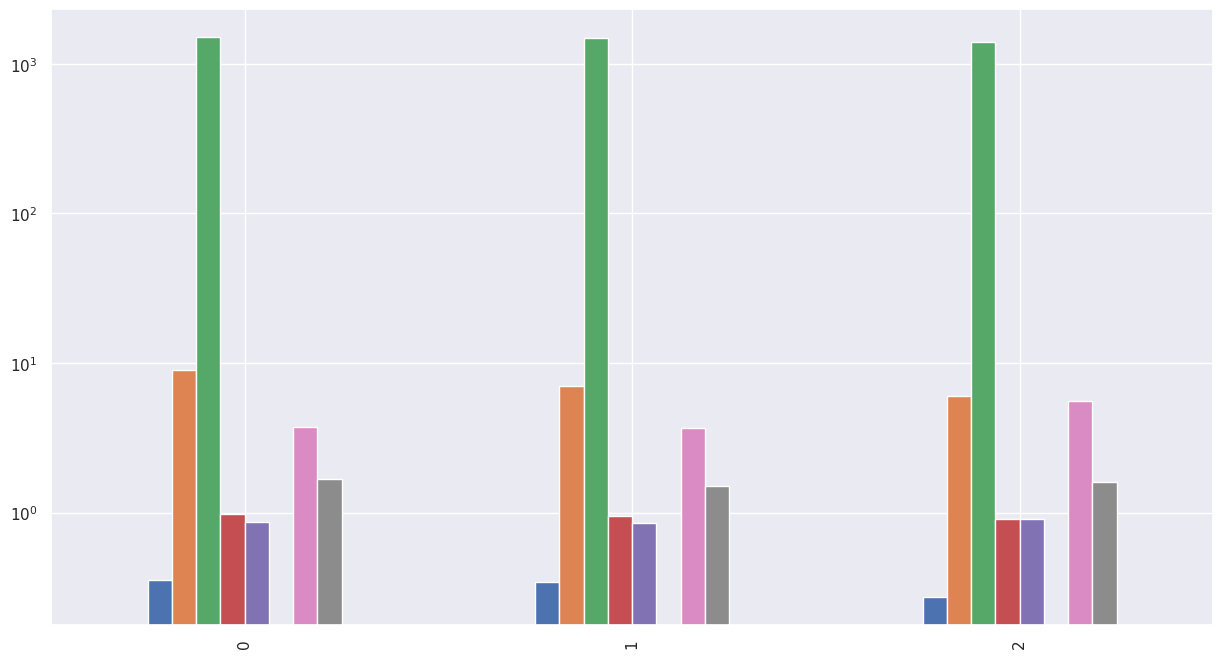

In [196]:
X[:3].plot(kind='bar', legend=False, logy=True);

In [197]:
X_normalized = X.copy()

# Normalizing each column using min-max scaler
for column in X.columns:
   
   X_normalized[column] = (X_normalized[column] - X_normalized[column].min()) / (X_normalized[column].max() - X_normalized[column].min())     

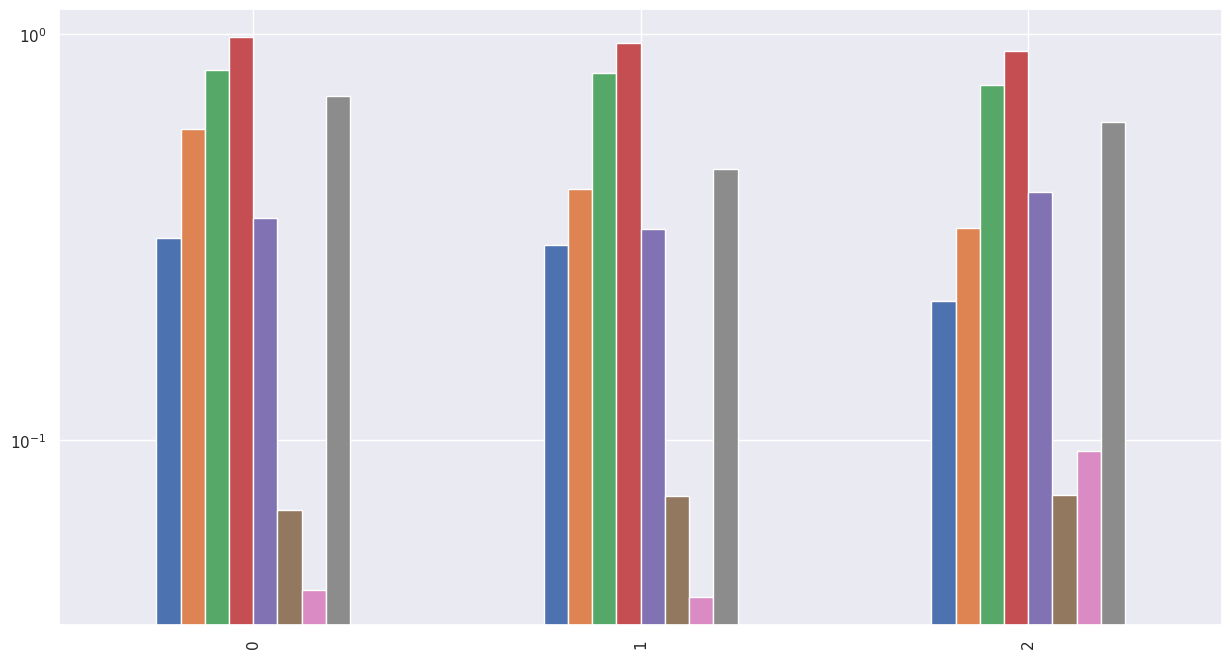

In [198]:
X_normalized[:3].plot(kind='bar', legend=False, logy=True);

In [199]:
enc = OrdinalEncoder()

ord = enc.fit_transform(y)

In [200]:
X['Model'] = ord.squeeze()

In [201]:
X.columns

Index(['QED', '# Heteroatoms', 'Synthetic Complexity',
       'Synthetic Accessibility', 'Weighted Interaction Similarity',
       'Docking score', 'RMSD', 'Interaction Weight Ratio', 'Model'],
      dtype='object')

In [202]:
X.corr().style.background_gradient(cmap='coolwarm', vmin=-1, vmax=1)

,QED,# Heteroatoms,Synthetic Complexity,Synthetic Accessibility,Weighted Interaction Similarity,Docking score,RMSD,Interaction Weight Ratio,Model
QED,1.000000,-0.068655,-0.813805,0.187683,0.311015,0.639950,0.437604,-0.409032,0.478375
# Heteroatoms,-0.068655,1.000000,0.151144,-0.323283,-0.116606,0.087576,-0.061436,-0.061780,0.252241
Synthetic Complexity,-0.813805,0.151144,1.000000,-0.226563,-0.465996,-0.677420,-0.385222,0.505579,-0.566250
Synthetic Accessibility,0.187683,-0.323283,-0.226563,1.000000,0.221235,0.041760,0.095352,0.008817,-0.013418
Weighted Interaction Similarity,0.311015,-0.116606,-0.465996,0.221235,1.000000,0.146683,-0.028003,-0.002397,0.222507
Docking score,0.639950,0.087576,-0.677420,0.041760,0.146683,1.000000,0.634950,-0.625218,0.311697
RMSD,0.437604,-0.061436,-0.385222,0.095352,-0.028003,0.634950,1.000000,-0.420558,0.011494
Interaction Weight Ratio,-0.409032,-0.061780,0.505579,0.008817,-0.002397,-0.625218,-0.420558,1.000000,-0.443393
Model,0.478375,0.252241,-0.566250,-0.013418,0.222507,0.311697,0.011494,-0.443393,1.000000


In [203]:
corrs = X.iloc[:15].copy()

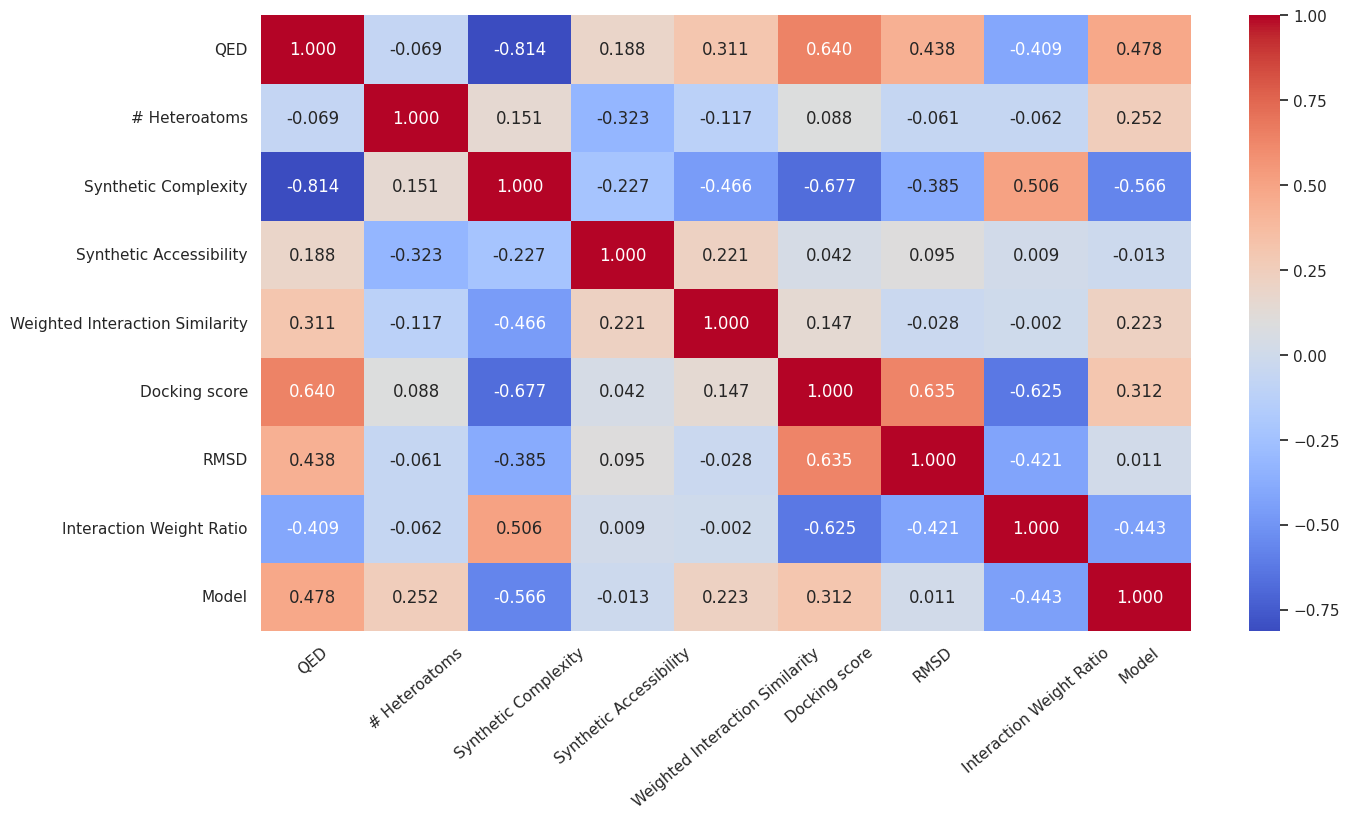

In [204]:
fig, ax = plt.subplots()
sns.heatmap(X.corr(method='pearson'), annot=True, fmt='.3f', 
            cmap=plt.get_cmap('coolwarm'), cbar=True, ax=ax)
ax.set_yticklabels(ax.get_yticklabels(), rotation="horizontal")
plt.xticks(rotation=40);

## Random Forest Classification

In [205]:
enc = OneHotEncoder(handle_unknown='ignore')

In [206]:
enc.fit_transform(y)

<794x4 sparse matrix of type '<class 'numpy.float64'>'
	with 794 stored elements in Compressed Sparse Row format>

In [207]:
X_train, X_test, y_train, y_test = train_test_split(X_normalized, y, test_size=.2, random_state=1)

In [208]:
len(X_train)

635

In [209]:
len(X_test)

159

In [210]:
rf = RandomForestClassifier(n_estimators=250,
                            class_weight='balanced',
                            random_state=1)

rf.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', n_estimators=250,
                       random_state=1)

In [211]:
y_pred = rf.predict(X_test)

In [215]:
precision = precision_score(y_pred, y_test, average='micro')

print(f'Average precision: {precision:.3f}')

print(classification_report(y_test, y_pred))

Average precision: 0.912
              precision    recall  f1-score   support

       coati       0.93      0.85      0.89        48
        crem       0.92      0.92      0.92        37
    reinvent       0.87      0.92      0.89        37
        safe       0.92      0.97      0.95        37

    accuracy                           0.91       159
   macro avg       0.91      0.92      0.91       159
weighted avg       0.91      0.91      0.91       159



In [213]:
weights = rf.feature_importances_
vars = X_normalized.columns

d = {'Features': vars, 'Weights': weights}

rf_features = pd.DataFrame(data=d).sort_values(['Weights'], ascending=False, ignore_index=True)

rf_features

,Features,Weights
0,Synthetic Complexity,0.206228
1,Weighted Interaction Similarity,0.176121
2,RMSD,0.147700
3,QED,0.146898
4,Docking score,0.146407
5,Interaction Weight Ratio,0.076167
6,Synthetic Accessibility,0.060994
7,# Heteroatoms,0.039485


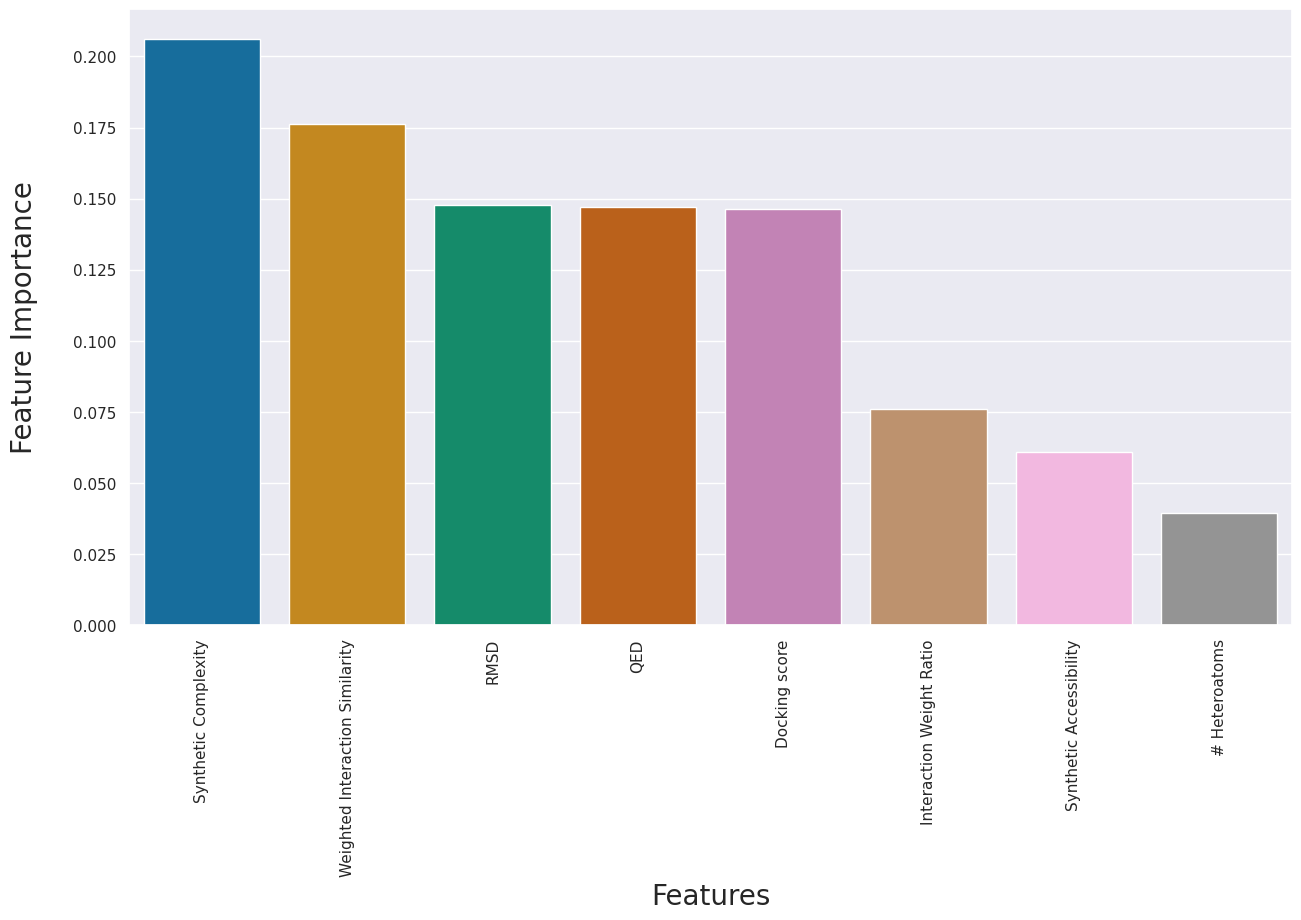

In [214]:
fig, ax = plt.subplots()

sns.barplot(x = 'Features',
			y = 'Weights',
			data = rf_features.loc[:15],
            palette='colorblind',
            ax=ax)

# plt.title('Ranking of Random Forest Features')
ax.set_xlabel('Features', fontsize=20)
ax.set_ylabel('Feature Importance', labelpad=25, fontsize=20)

plt.xticks(rotation=90)

# Show the plot
plt.show()


### AdaBoost

In [136]:
clf = AdaBoostClassifier(n_estimators=100, algorithm="SAMME", random_state=1)

clf.fit(X_train, y_train)

AdaBoostClassifier(algorithm='SAMME', n_estimators=100, random_state=1)

In [137]:
y_pred = clf.predict(X_test)

In [138]:
clf.score(X_test, y_test)

0.8742138364779874

In [139]:
weights = clf.feature_importances_
vars = X_normalized.columns

d = {'vars': vars, 'weights': weights}

adaboost_features = pd.DataFrame(data=d).sort_values(['weights'], ascending=False, ignore_index=True)

adaboost_features

,vars,weights
0,Docking score,0.316629
1,desc_Bertz,0.207383
2,rmsd,0.201383
3,Weighted IFP Similarity,0.101992
4,interaction weight ratio,0.093345
5,desc_QED,0.038145
6,RAScore_pred_proba,0.031654
7,desc_NumHeteroatoms,0.009470


## Visualizations

### Visualizing Interaction Fingerprints

In [140]:
ifp_crem.drop(['ID'], axis=1, inplace=True)

visualize_fingerprint(ifp_crem)

KeyError: "['ID'] not found in axis"

In [141]:
ifp_coati.drop(['ID'], axis=1, inplace=True)

visualize_fingerprint(ifp_coati)

KeyError: "['ID'] not found in axis"

In [142]:
ifp_safe.drop(['ID'], axis=1, inplace=True)

visualize_fingerprint(ifp_safe)

KeyError: "['ID'] not found in axis"

In [143]:
ifp_reinvent.drop(['ID'], axis=1, inplace=True)

visualize_fingerprint(ifp_reinvent)

KeyError: "['ID'] not found in axis"

In [144]:
len(ifp_safe.columns), len(ifp_coati.columns), len(ifp_crem.columns), len(ifp_reinvent.columns)

(87, 75, 60, 63)

### Visualizing Model Differences

In [216]:
model_df['Weighted IFP Similarity'] = X['Weighted IFP Similarity']

KeyError: 'Weighted IFP Similarity'

In [217]:
df = df.merge(model_df[['SMILES', 'Model', 'Docking score', 'num_interactions', 'weighted_interactions', 'num_VdW', 'num_hydrophobic', 'num_HBAcceptor', 'num_ionic', 'rmsd', 'Weighted IFP Similarity']], left_on='smiles', right_on='SMILES', how='left')

KeyError: "['Weighted IFP Similarity'] not in index"

In [218]:
df.drop(['SMILES'], axis=1, inplace=True)

KeyError: "['SMILES'] not found in axis"

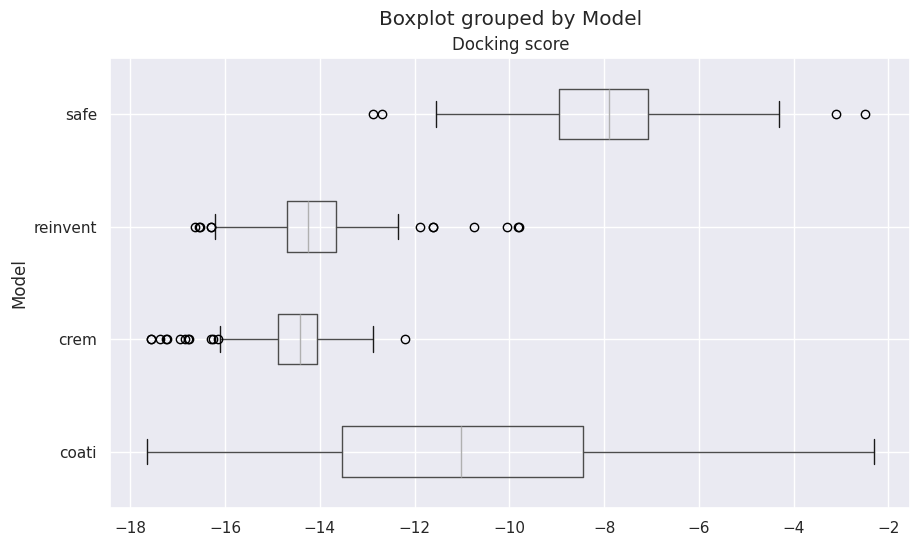

In [ ]:
fig, ax = plt.subplots(figsize=(10, 6))

params = {'vert' : 0}

df.boxplot(column=['Docking score'], by='Model', ax=ax, **params)

ax = plt.gca()

In [219]:
# Create a FacetGrid with KDE plots
g = sns.FacetGrid(df, hue="Model", height=5, aspect=1.5)
g.map(sns.kdeplot, "Docking score", shade=True).add_legend()

# Add title and labels
g.fig.suptitle('Distributions of Docking Score by Model')
g.set_axis_labels('Docking Score', 'Density')

plt.show()

KeyError: 'Model'

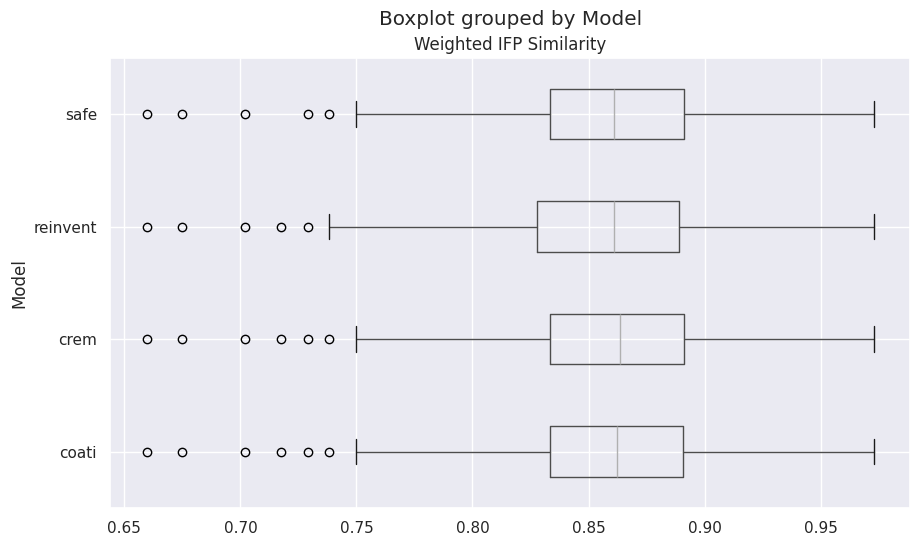

In [150]:
fig, ax = plt.subplots(figsize=(10, 6))

params = {'vert' : 0}

df.boxplot(column=['Weighted IFP Similarity'], by='Model', ax=ax, **params)

ax = plt.gca()

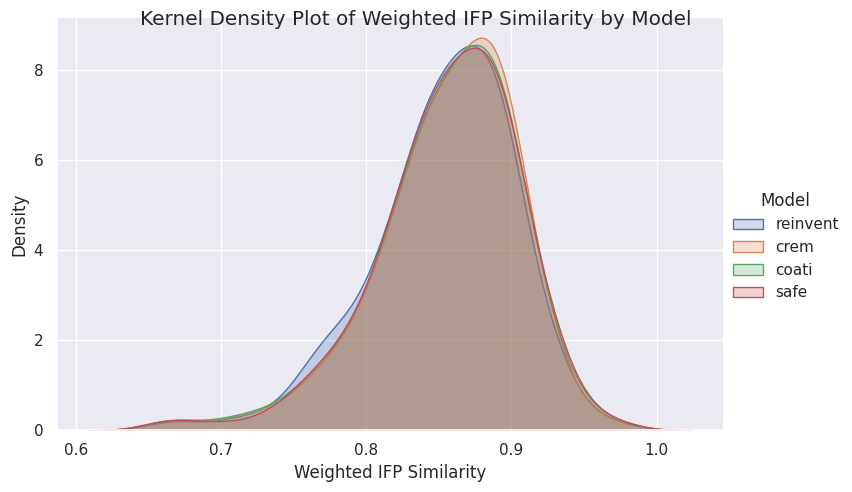

In [151]:
# Create a FacetGrid with KDE plots
g = sns.FacetGrid(df, hue="Model", height=5, aspect=1.5)
g.map(sns.kdeplot, "Weighted IFP Similarity", shade=True).add_legend()

# Add title and labels
g.fig.suptitle('Kernel Density Plot of Weighted IFP Similarity by Model')
g.set_axis_labels('Weighted IFP Similarity', 'Density')

plt.show()

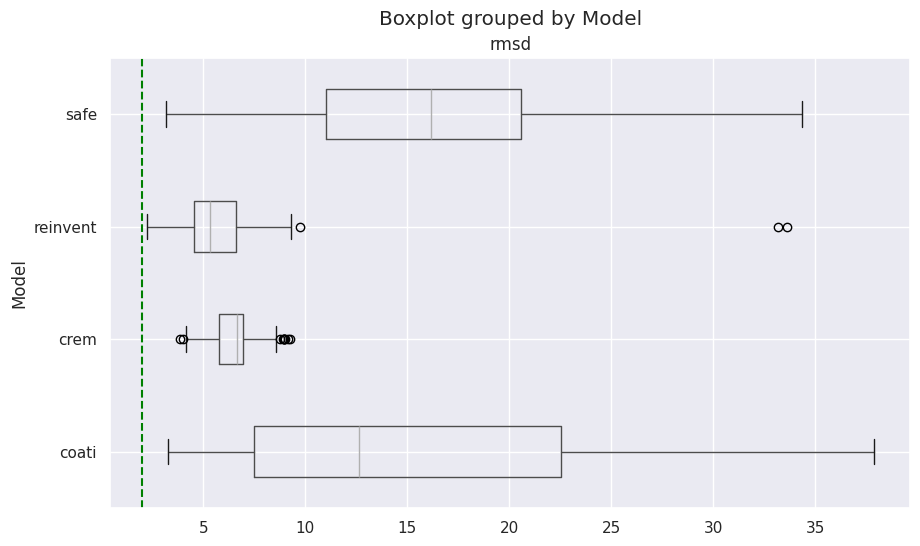

In [152]:
fig, ax = plt.subplots(figsize=(10, 6))

params = {'vert' : 0}

df.boxplot(column=['rmsd'], by='Model', ax=ax, **params)

ax = plt.gca()

plt.axvline(x=2, ls='dashed', c='green');

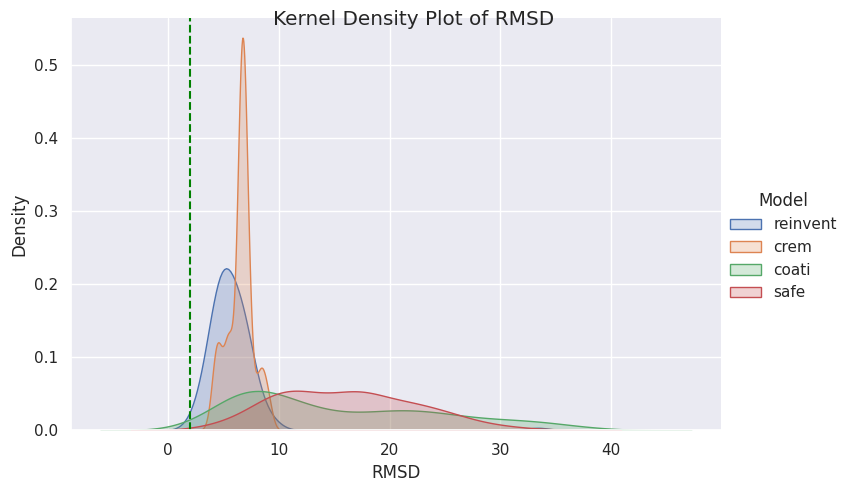

In [153]:
# Create a FacetGrid with KDE plots
g = sns.FacetGrid(df, hue="Model", height=5, aspect=1.5)
g.map(sns.kdeplot, "rmsd", shade=True).add_legend()
plt.axvline(x=2, ls='dashed', c='green')
# Add title and labels
g.fig.suptitle('Kernel Density Plot of RMSD')
g.set_axis_labels('RMSD', 'Density')

plt.show()

KeyError: 'Column not found: tanimoto_Sim'

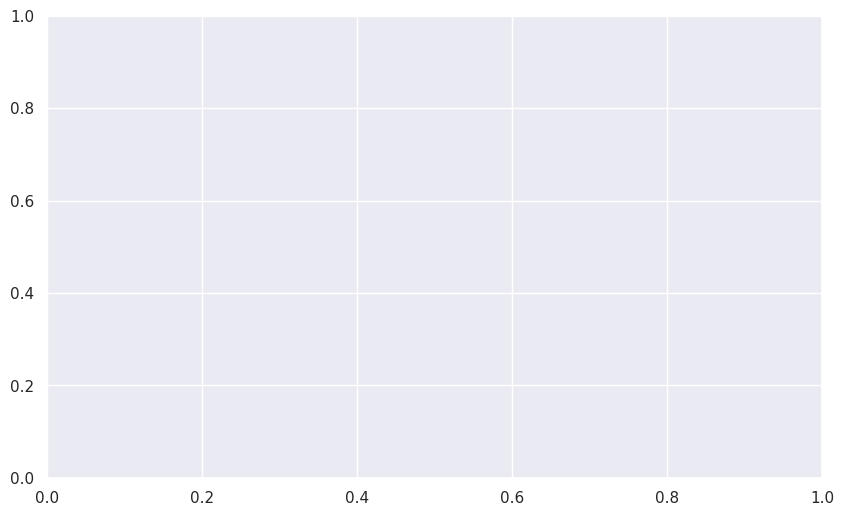

In [154]:
fig, ax = plt.subplots(figsize=(10, 6))

params = {'vert' : 0}

df.boxplot(column=['tanimoto_Sim'], by='Model', ax=ax, **params)

ax = plt.gca()

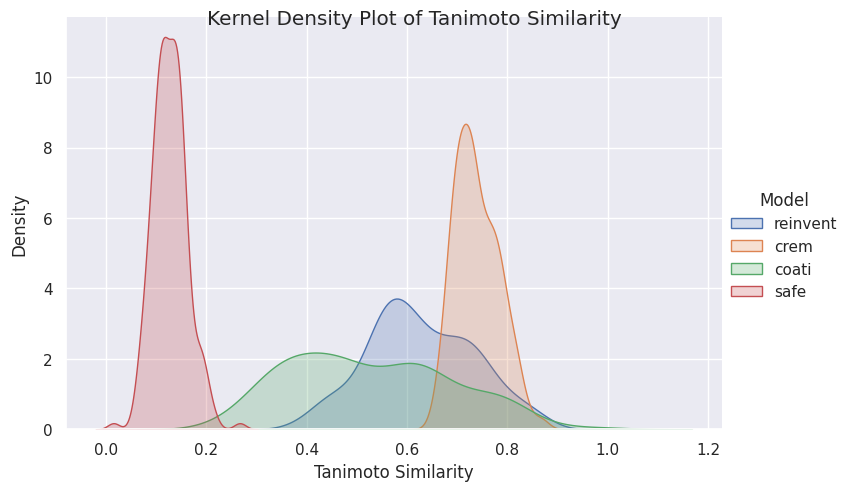

In [ ]:
# Create a FacetGrid with KDE plots
g = sns.FacetGrid(df, hue="Model", height=5, aspect=1.5)
g.map(sns.kdeplot, "tanimoto_Sim", shade=True).add_legend()

# Add title and labels
g.fig.suptitle('Kernel Density Plot of Tanimoto Similarity')
g.set_axis_labels('Tanimoto Similarity', 'Density')

plt.show()

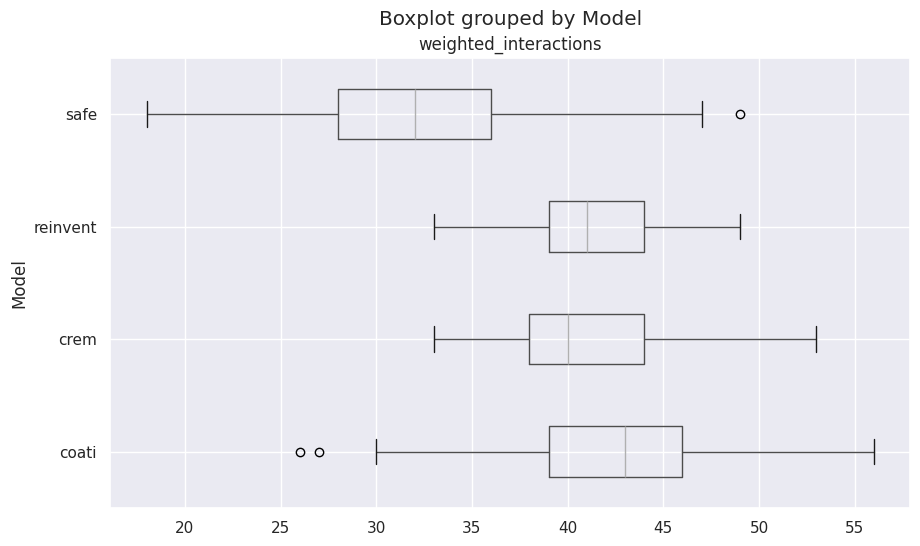

In [ ]:
fig, ax = plt.subplots(figsize=(10, 6))

params = {'vert' : 0}

df.boxplot(column=['weighted_interactions'], by='Model', ax=ax, **params)

ax = plt.gca()

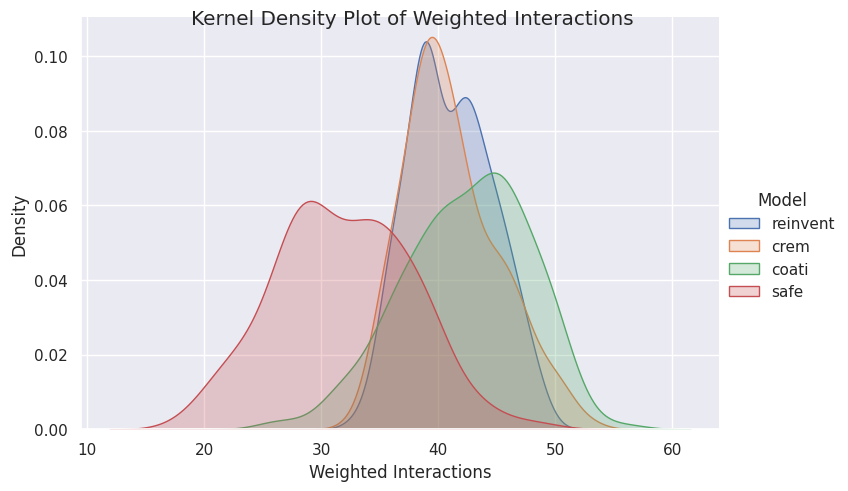

In [ ]:
# Create a FacetGrid with KDE plots
g = sns.FacetGrid(df, hue="Model", height=5, aspect=1.5)
g.map(sns.kdeplot, 'weighted_interactions', shade=True).add_legend()

# Add title and labels
g.fig.suptitle('Kernel Density Plot of Weighted Interactions')
g.set_axis_labels('Weighted Interactions', 'Density')

plt.show()

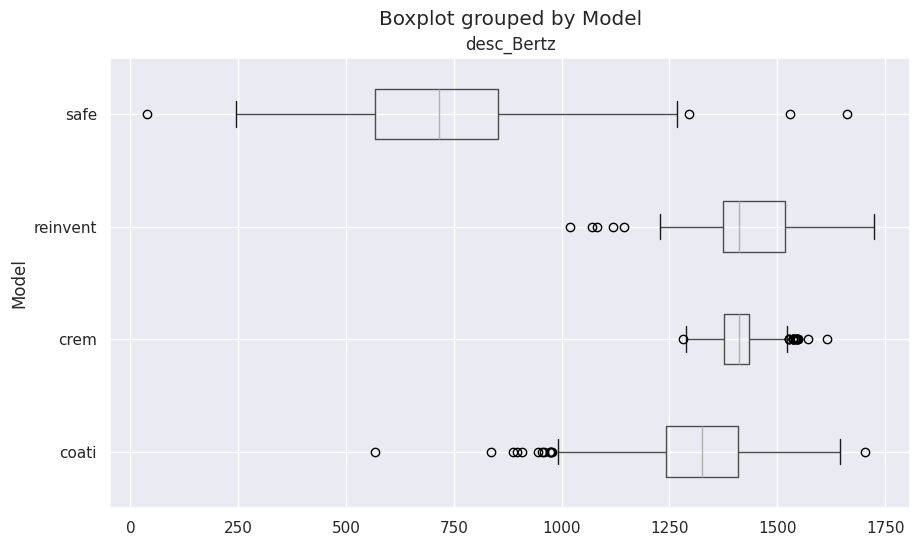

In [ ]:
fig, ax = plt.subplots(figsize=(10, 6))

params = {'vert' : 0}

df.boxplot(column=['desc_Bertz'], by='Model', ax=ax, **params)

ax = plt.gca()

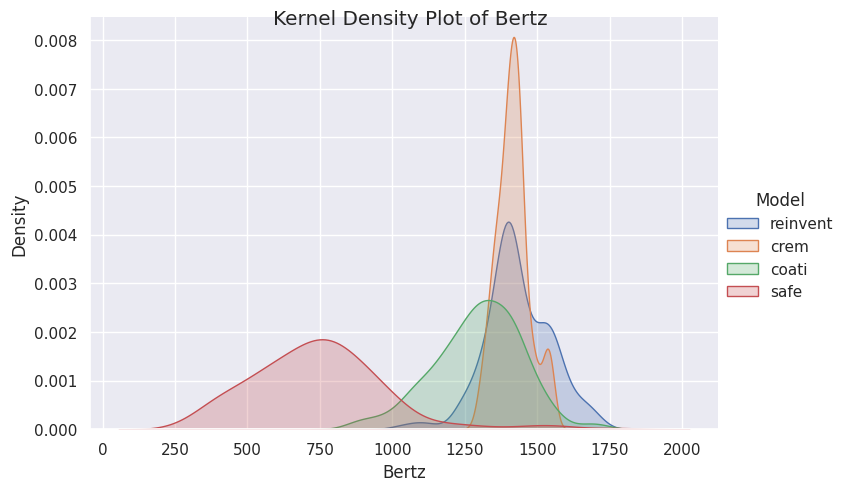

In [155]:
# Create a FacetGrid with KDE plots
g = sns.FacetGrid(df, hue="Model", height=5, aspect=1.5)
g.map(sns.kdeplot, 'desc_Bertz', shade=True).add_legend()

# Add title and labels
g.fig.suptitle('Kernel Density Plot of Bertz')
g.set_axis_labels('Bertz', 'Density')

plt.show()

In [156]:
var = 'desc_FormalCharge'

plt.figure(figsize=(10, 6))
sns.histplot(data=df, x=var, hue='Model', multiple='dodge', palette='colorblind', bins=3, binwidth=.6,)

plt.xlabel('Formal Charge')
plt.ylabel('Frequency')
plt.title('Formal Charge by Model')

plt.show();

ValueError: Could not interpret value `desc_FormalCharge` for `x`. An entry with this name does not appear in `data`.

<Figure size 1000x600 with 0 Axes>

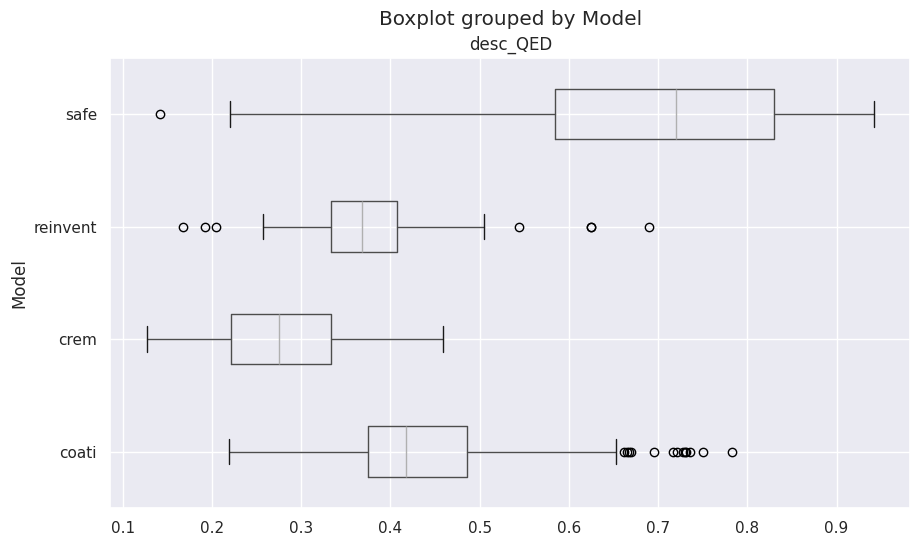

In [ ]:
fig, ax = plt.subplots(figsize=(10, 6))

params = {'vert' : 0}

df.boxplot(column=['desc_QED'], by='Model', ax=ax, **params)

ax = plt.gca()

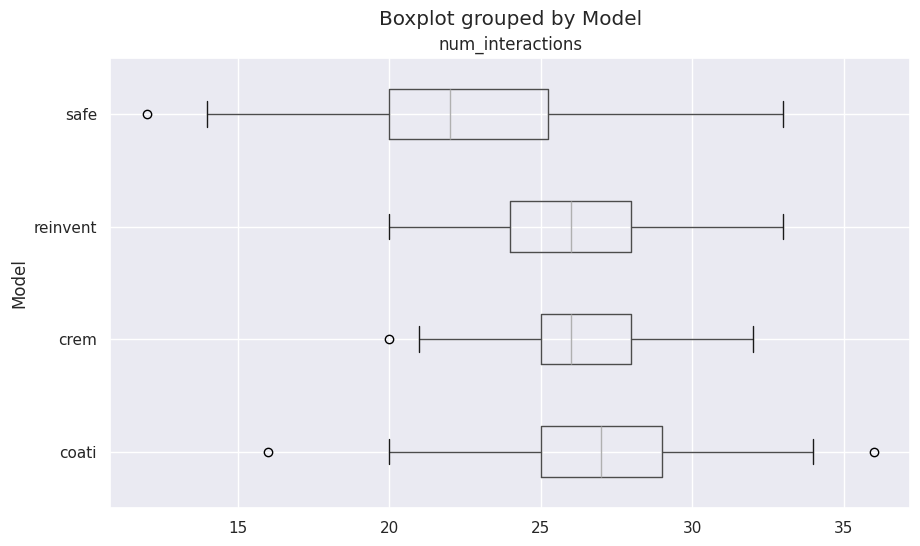

In [ ]:
fig, ax = plt.subplots(figsize=(10, 6))

params = {'vert' : 0}

df.boxplot(column=['num_interactions'], by='Model', ax=ax, **params)

ax = plt.gca()

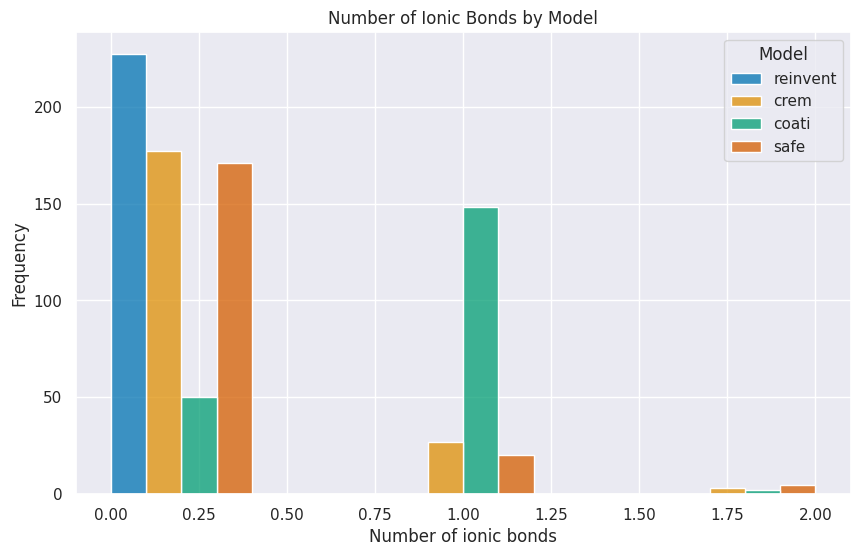

In [ ]:
var = 'num_ionic'

plt.figure(figsize=(10, 6))
sns.histplot(data=df, x=var, hue='Model', multiple='dodge', palette='colorblind', bins=3, binwidth=.4,)

plt.xlabel('Number of ionic bonds')
plt.ylabel('Frequency')
plt.title('Number of Ionic Bonds by Model')

plt.show();

### Visualizing clusters w/ PCA and t-SNE

In [157]:
scaler = StandardScaler()
X_normalized = scaler.fit_transform(X_normalized)

In [158]:
pca = PCA(n_components=3, random_state=0)
pca_fps = pca.fit_transform(X_normalized)

In [159]:
var1, var2, var3 = pca.explained_variance_ratio_

In [160]:
var1, var2, var3

(0.42105180783381785, 0.19243790967679017, 0.12731058072867343)

In [161]:
model_df['PC1'], model_df['PC2'], model_df['PC3'] = pca_fps.T[0], pca_fps.T[1], pca_fps.T[2]

In [162]:
plot_df = model_df.sample(500)

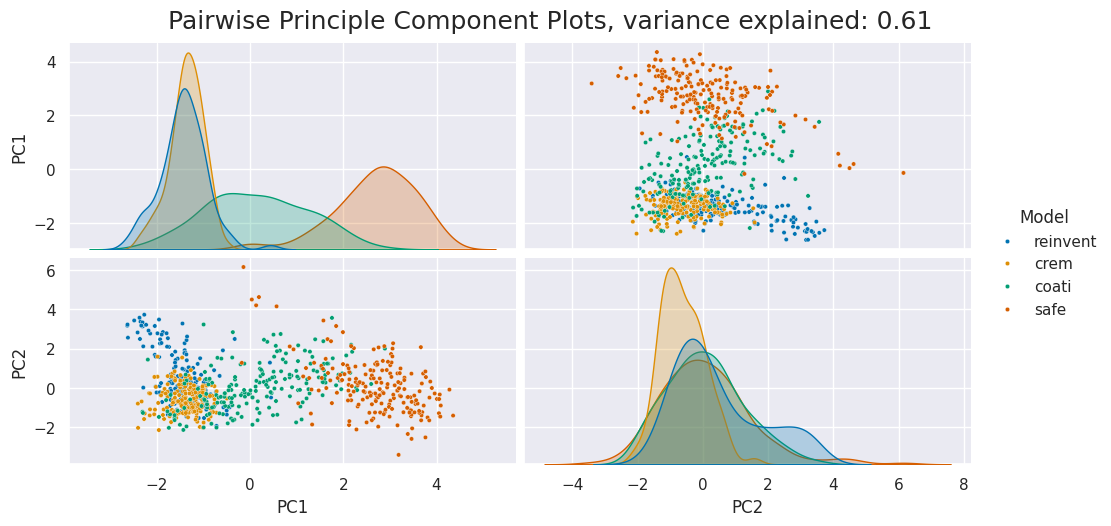

In [163]:
f = sns.pairplot(model_df,
                 hue='Model',
                 vars=['PC1', 'PC2'],
                 palette='colorblind',
                 aspect=2,
                 plot_kws=dict(s=10))

f.fig.suptitle(f'Pairwise Principle Component Plots, variance explained: {var1 + var2:.2f}', fontsize=18, y=1.04);

In [168]:
p = 50

pca_model = PCA(n_components=3, random_state=0)
tsne_model = TSNE(n_components=2, random_state=0, perplexity=p, n_iter=5000)
tsne_fps = tsne_model.fit_transform(pca_model.fit_transform(X))

In [169]:
model_df['TSNE1'], model_df['TSNE2'] = tsne_fps.T[0], tsne_fps.T[1]

In [170]:
plot_df = df.sample(n=500)

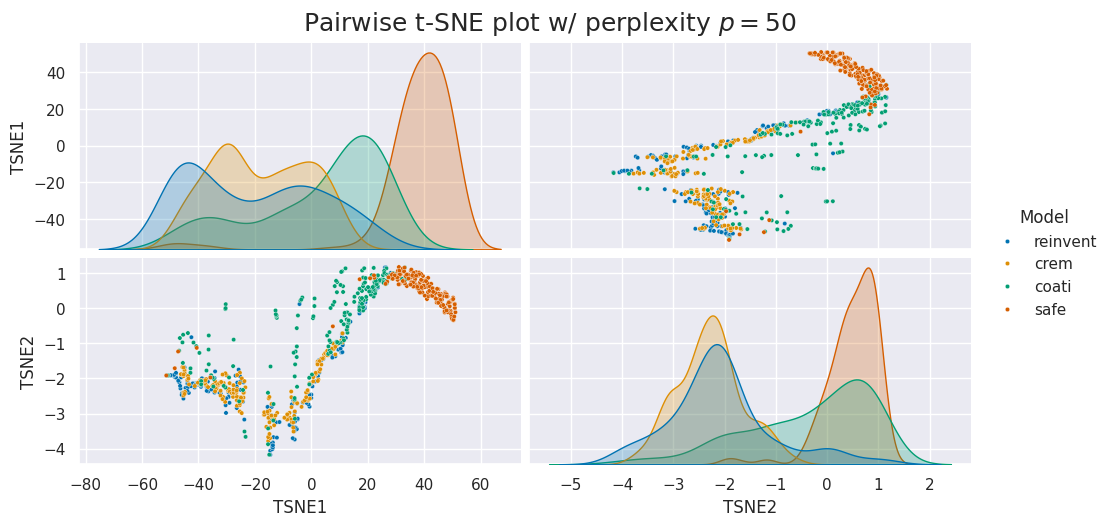

In [171]:
f = sns.pairplot(model_df,
                 hue='Model',
                 vars=['TSNE1', 'TSNE2'],
                 palette='colorblind',
                 aspect=2,
                 plot_kws=dict(s=10))

title = f'Pairwise t-SNE plot w/ perplexity $p={p}$'

f.fig.suptitle(title, fontsize=18, y=1.04);